In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

##### Reading data

In [35]:
dirpath = '/Users/parulgaba/Desktop/Capstone-Ethos/ConfidentialData/csvdata/'

data_path = '/Users/parulgaba/Desktop/Capstone-Ethos/ethos-retail-model/data/'

filename = data_path + 'regression_data/' + 'aggregated_summary_store_type_12_weeks.csv'
chunksize = 10 ** 5
rows=0
summary_df = pd.DataFrame()
for chunk in pd.read_csv(filename, chunksize=chunksize):
    summary_df=pd.concat([summary_df,chunk])
    rows+=chunk.shape[0]
    
summary_df.fillna(0)
print(summary_df.shape)
print (rows)

(476711, 47)
476711


In [36]:
summary_df['stock_prevailing_mrp'] = summary_df['stock_prevailing_mrp'].div(10000)
summary_df['billing'] = summary_df['billing'].div(10000)

In [37]:
items_no_sales = summary_df.groupby(['item_no']).agg({'sales_quantity':'sum'}).reset_index()
unique_item_no_sales = items_no_sales[items_no_sales['sales_quantity'] == 0]['item_no'].unique()
summary_df = summary_df[~summary_df['item_no'].isin(unique_item_no_sales)]
print("Unique items removed with no sales at all for all 3 three years : " + str(len(unique_item_no_sales)))

Unique items removed with no sales at all for all 3 three years : 4324


In [38]:
summary_df.shape

(438196, 47)

In [39]:
summary_df['item_no']=summary_df['item_no'].astype(str)
summary_df['period']=summary_df['period'].astype(int)
summary_df['case_shape']=summary_df['case_shape'].astype(str)


In [40]:
len(summary_df['item_no'].unique())

14749

In [41]:
brands = summary_df['brand'].unique()

In [42]:
item_cols = ['case_size_range', 'gender','movement', 'material', 'dial_color', 'strap_type', 'strap_color','precious_stone', 'glass', 'case_shape', 'watch_type']



In [43]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Create a new df with Other items

summary_item_pareto_final = pd.DataFrame()
list = []
item_mapping_list = []
for brand in brands:
    items_combined_df = pd.DataFrame()

    summary_by_brand_df = summary_df[summary_df['brand'] == brand]
    item_series = summary_by_brand_df.fillna(0).groupby('item_no').agg({'billing':'sum'}).sort_values('billing',ascending=False)
    items_combined_df = pd.concat([items_combined_df, item_series])
    
    mask=items_combined_df.cumsum()/items_combined_df.sum()>0.95
    mask=mask.iloc[:,0]
    
    levels=len(summary_by_brand_df['item_no'].unique())
    
    if levels > 100:
        summary_by_brand_df['brand'] = np.where(summary_by_brand_df['item_no'].isin(item_series[mask].index),'Others',summary_by_brand_df['brand'])         
        summary_by_brand_df['item_no'] = np.where(summary_by_brand_df['item_no'].isin(item_series[mask].index),'Others',summary_by_brand_df['item_no'])
        item_mapping_list = item_mapping_list + item_series[mask].index.to_list()
        for col in item_cols:
            if summary_df[col].mode()[0] == 'NaN':
                print(brand)
                print (col)
                print(summary_df[col].mode()[0])
            summary_by_brand_df[col] = np.where(summary_by_brand_df['item_no'].isin(item_series[mask].index),summary_df[col].mode()[0],summary_by_brand_df[col])
    
    new_levels=len(summary_by_brand_df['item_no'].unique())
    
    freq=summary_by_brand_df['item_no'].value_counts()/summary_by_brand_df['item_no'].value_counts().sum()*100
    freq=freq.round(2)
    
    sale_qty=summary_by_brand_df.groupby(['item_no']).agg({'sales_quantity':'sum'}).sort_values('sales_quantity',ascending=False)
    sale_qty=sale_qty/sale_qty.sum()*100
    sale_qty=sale_qty.round(2)
    
    try:
        Other_Sales_Qty=sale_qty['sales_quantity']['Others']
    except:
        Other_Sales_Qty=0
    bill=summary_by_brand_df.groupby(['item_no']).agg({'billing':'sum'}).sort_values('billing',ascending=False)
    bill=bill/bill.sum()*100
    bill=bill.round(2)
    try:
        Other_bill=bill['billing']['Others']
    except:
        Other_bill=0
        
    list.append([brand, levels, new_levels,Other_bill,Other_Sales_Qty])
    
    cols=['Brand', 'Orig SKU count', 'New SKU count', 'Other%(Billing)', 'Other%(Sales Qty)']
    item_pareto_summary = pd.DataFrame(list, columns=cols)
    item_pareto_summary=item_pareto_summary.set_index("Brand")
    
    summary_item_pareto_final = pd.concat([summary_item_pareto_final, summary_by_brand_df])
#items_combined_df.head(5)


In [44]:
print (len(summary_item_pareto_final['item_no'].unique()))

10589


In [45]:
item_pareto_summary.sort_values(by = ['Other%(Sales Qty)'], ascending=False).head()

,Orig SKU count,New SKU count,Other%(Billing),Other%(Sales Qty)
Brand,,,,
B046,156,119,5.10,22.17
B124,120,84,5.14,19.76
B023,197,138,5.11,19.24
B094,591,409,5.02,17.50
B014,391,258,5.07,13.97


In [46]:
summary_item_pareto_final[summary_item_pareto_final['item_no'] == 'Others'].shape

(26292, 47)

In [47]:
print (len(summary_df['item_no'].unique()))
print (len(summary_item_pareto_final['item_no'].unique()))

14749
10589


In [48]:
len(item_mapping_list)

4159

In [49]:
summarize_method = {
        'brand' :'first', 'store_location' :'first',
       'city_type' :'first', 'region' :'first', 'quantity' :'mean', 'purchase_quantity' :'mean',
       'transfer_quantity' :'mean', 'available_quantity' :'mean', 'sales_quantity' :'mean',
       'purchase_cost_amount' :'mean', 'purchase_mrp' :'mean', 'purchase_date' :'first',
       'stock_prevailing_mrp' :'mean', 'store_in' :'first', 'product_group_code' :'first',
       'transfer_cost_amount' :'mean', 'sales_department' :'first', 'days_to_sell' :'mean',
       'num_of_customers' :'mean', 'total_price' :'mean', 'line_discount' :'mean', 'crm_line_discount' :'mean',
       'discount' :'mean', 'tax' :'mean', 'cost' :'mean', 'billing' :'mean', 'contribution' :'mean', 'trade_incentive' :'mean',
       'trade_incentive_value' :'mean', 'total_contribution' :'mean', 'case_size' :'mean',
       'case_size_range' :'first', 'gender' :'first', 'movement' :'first', 'material' :'first', 'dial_color' :'first',
       'strap_type' :'first', 'strap_color' :'first', 'precious_stone' :'first', 'glass' :'first', 'case_shape' :'first',
       'watch_type' :'first', 'area_code' :'first'
}


sales_sum_df = summary_item_pareto_final.groupby(['store_type','item_no','period','state']).agg(summarize_method).reset_index()
sales_sum_df.shape



(412140, 47)

## Adding log S/So - Location code

In [50]:
#reading market shares
market_share=pd.read_excel(data_path + "market_share_encoded.xlsx", header=0,index_col=0)

#computing market size for each state-period
market_sizes=sales_sum_df.groupby(['state','period']).agg({'sales_quantity':'sum'})
market_sizes=market_sizes.reset_index()
market_sizes=pd.merge(market_sizes,market_share, left_on='state', right_on='SubCode', how='left')#.drop('Attribute_x', axis=1)
market_sizes['Market Size']=market_sizes['sales_quantity'].div(market_sizes['Market Share'], axis=0)

#computing number of stores per state
x=sales_sum_df.groupby(['state','period'])['store_type'].unique()
l=[]
store_nos=pd.DataFrame()
for i in range(len(x)):
    l.append([x.index[i][0],x.index[i][1],len(x[i])])
cols=['state','period','Store numbers']
store_nos = pd.DataFrame(l, columns=cols)

#merging market sizes with number of stores per market
market_sizes=pd.merge(market_sizes,store_nos, how='inner')

#computing market size per store
market_sizes['per store market']=market_sizes['Market Size']/market_sizes['Store numbers']

#adding market share per store-period to the main data
market_sizes=market_sizes[['state','period','per store market']]#extracting only relevant columns from market_sizes
merge_cols=['state','period']
summary_with_market_shares=pd.merge(sales_sum_df,market_sizes, on=merge_cols,how='inner')

#computing So

# summary_with_market_shares['so'] = summary_with_market_shares['per store type market']-summary_with_market_shares['sales_quantity']

summary_with_market_shares['so']=summary_with_market_shares['per store market']-summary_with_market_shares['sales_quantity']
summary_with_market_shares = summary_with_market_shares.fillna(0)[summary_with_market_shares['so'] != 0]

#computing log(S/So) [replacing zeros with 1e-08 so that logs dont create a problem]
summary_with_market_shares['so']=summary_with_market_shares['sales_quantity'].div(summary_with_market_shares['so'],axis=0)
summary_with_market_shares['so'] = summary_with_market_shares['so'].replace(0,10**(-5))

summary_with_market_shares['so']=np.log(summary_with_market_shares['so'])



In [51]:
print(len(summary_with_market_shares[summary_with_market_shares['so'].isin([np.inf, -np.inf, np.nan])]))


0


In [52]:
#summary_with_market_shares = summary_with_market_shares[~(summary_with_market_shares['so'].isin([np.inf, -np.inf, np.nan]))]

In [53]:
#checking for NaNs
d=summary_with_market_shares[['sales_quantity','per store market','so']]
d[d.isna().any(axis=1)]

,sales_quantity,per store market,so


In [54]:
summary_with_market_shares['so'].head()

0   -11.512925
1   -11.512925
2   -11.512925
3   -11.512925
4   -11.512925
Name: so, dtype: float64

In [55]:
summary_with_market_shares['per store market'].head()

0    2374.581427
1    2374.581427
2    2374.581427
3    2374.581427
4    2374.581427
Name: per store market, dtype: float64

In [56]:
#summary_with_market_shares.to_excel(data_path + 'summary_with_market_shares_pd14.xlsx')
summary_with_market_shares['period'] = summary_with_market_shares['period'].astype('int')


In [82]:
#extracting specific columns

col=[ 'item_no','period', 'state', 'region',
       'brand', 'stock_prevailing_mrp', 'store_type', 'store_location', 'city_type', 'case_size_range',
       'gender', 'movement', 'material', 'dial_color', 'strap_type',
       'strap_color', 'precious_stone', 'glass', 'case_shape', 'watch_type','billing','sales_quantity','so']

summary_final=summary_with_market_shares.loc[:,col]
#df_north_final.fillna(0, inplace=True)

summary_final['item_no']=summary_final['item_no'].astype(str)
summary_final['period']=summary_final['period'].astype(int)
summary_final['case_shape']=summary_final['case_shape'].astype(str)


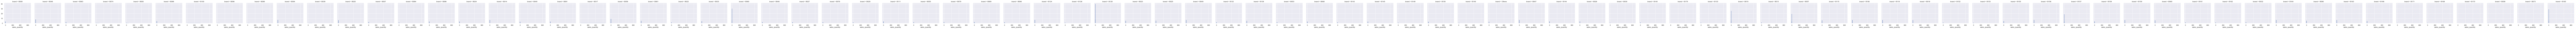

In [58]:
sns.set(rc={'figure.figsize':(20,20)})
g = sns.FacetGrid(summary_final, col='brand')
g = g.map(sns.kdeplot, 'sales_quantity')

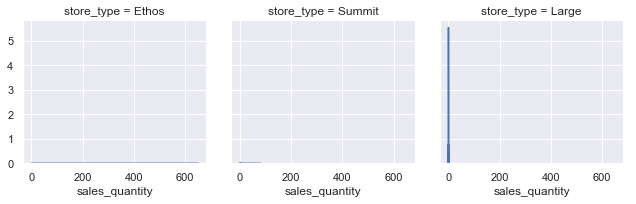

In [59]:
sns.set(rc={'figure.figsize':(20,20)})
g = sns.FacetGrid(summary_final, col='store_type')
g = g.map(sns.kdeplot, 'sales_quantity')

In [64]:
sns.set(rc={'figure.figsize':(7,5)})

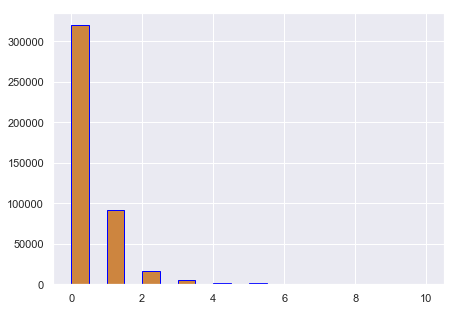

In [65]:
plt.hist(summary_df['sales_quantity'], facecolor='peru', edgecolor='blue', bins = 20, range=(0,10))
plt.show()

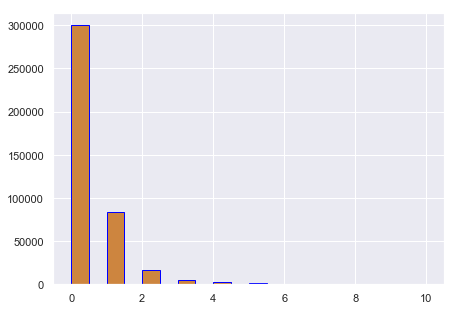

In [66]:
plt.hist(summary_final['sales_quantity'], facecolor='peru', edgecolor='blue', bins = 20, range=(0,10))
plt.show()

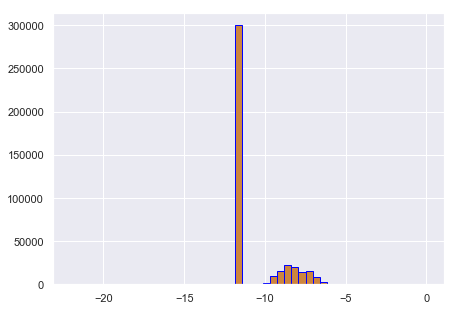

In [67]:
sns.set(rc={'figure.figsize':(7,5)})
plt.hist(summary_with_market_shares['so'], facecolor='peru', edgecolor='blue', bins = 50, range=(-22,0))
plt.show()

In [26]:
summary_final['so'].describe()

count    410267.000000
mean        -10.604231
std           1.559477
min         -11.512925
25%         -11.512925
50%         -11.512925
75%          -9.387476
max          -0.847298
Name: so, dtype: float64

In [27]:
summary_with_market_shares[summary_with_market_shares['so'] >= -1]['billing']

359210    63.320
379314     7.205
Name: billing, dtype: float64

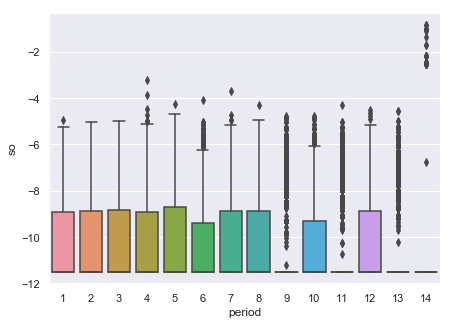

In [60]:
sns.set(rc={'figure.figsize':(7,5)})
sns.boxplot(x='period',y='so',data=summary_with_market_shares)

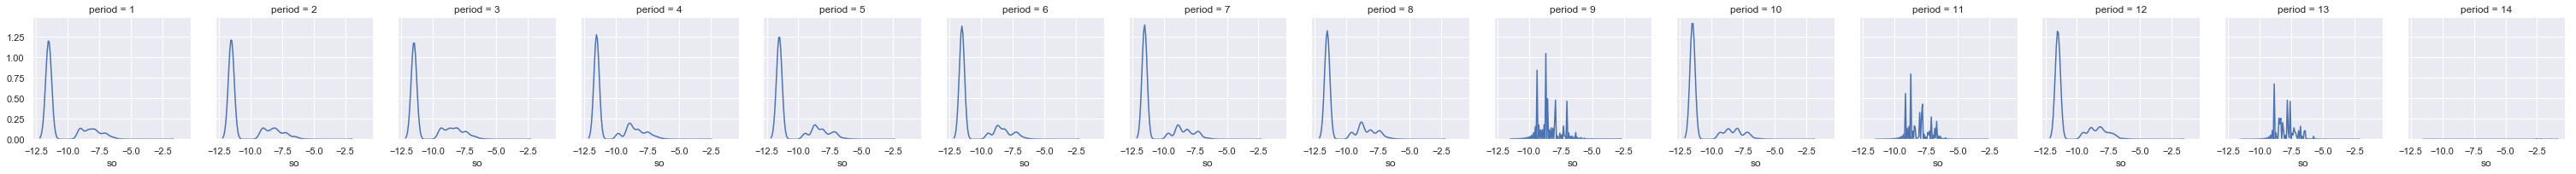

In [35]:
sns.set(rc={'figure.figsize':(20,20)})
g = sns.FacetGrid(summary_with_market_shares, col='period')
g = g.map(sns.kdeplot, 'so')

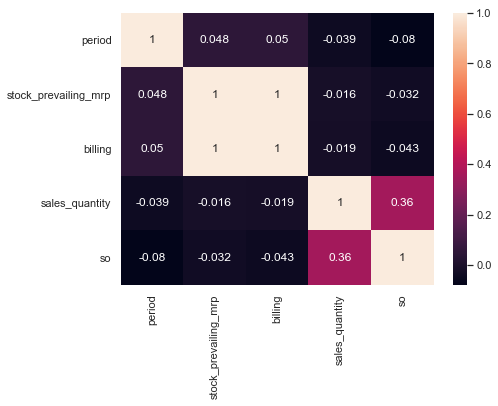

In [36]:
sns.set(rc={'figure.figsize':(7,5)})
sns.heatmap(summary_final.corr(), annot=True)

### Remove the outlier sales from last quarter - covid period

In [68]:
summary_final = summary_final[summary_final['period'] != 14]


In [83]:
summary_final.shape

(390154, 23)

In [84]:
def pareto(df_param,cols):
    lst=[]
    df = pd.DataFrame()
    df = pd.concat([df, df_param])
    feature_mapping = {}
    for col in cols:
                
        series=df.fillna(0).groupby([col]).agg({'billing':'sum'}).sort_values('billing',ascending=False)
        mask=series.cumsum()/series.sum()>0.9 
        #nos=mask.value_counts()[1]
        mask=mask.iloc[:,0]
        levels=len(df[col].unique())
        
        if levels>10:
            df[col] = np.where(df[col].isin(series[mask].index),'Other',df[col])
            feature_mapping[col]=series[mask].index.to_list()
        new_levels=len(df[col].unique())

        freq=df[col].value_counts()/df[col].value_counts().sum()*100
        freq=freq.round(2)

        sale_qty=df.groupby([col]).agg({'sales_quantity':'sum'}).sort_values('sales_quantity',ascending=False)
        sale_qty=sale_qty/sale_qty.sum()*100
        sale_qty=sale_qty.round(2)
        try:
            Other_Sales_Qty=sale_qty['sales_quantity']['Other']
        except:
            Other_Sales_Qty=0
        
        bill=df.groupby([col]).agg({'billing':'sum'}).sort_values('billing',ascending=False)
        bill=bill/bill.sum()*100
        bill=bill.round(2)
        try:
            Other_bill=bill['billing']['Other']
        except:
            Other_bill=0
        
        #comparison=mrp.merge(sale_qty, left_index=True, right_index=True)
        lst.append([col.upper(),levels, new_levels,Other_bill,Other_Sales_Qty])
        #print ("%s-Originally %d levels,combined %d levels into 'Other'.New Levels %d.By MRP,Other is %2.1f and by sale qty others is %2.1f"%(col.upper(),levels, levels-new_levels, new_levels,mrp['stock_prevailing_mrp']['Other'],sale_qty['sales_quantity']['Other']))
    
    cols=['Feature', 'Orig Levels', 'New Levels', 'Other%(Billing)', 'Other%(Sales Qty)']
    df1 = pd.DataFrame(lst, columns=cols)
    df1=df1.set_index("Feature")
    
    return df1,df,feature_mapping

In [85]:
import numpy as np
#cols=['brand','case_size', 'case_size_range', 'gender', 'material', 'dial_color', 'strap_type', 'strap_color','precious_stone', 'glass', 'watch_type']
cols=['case_size_range', 'gender','movement', 'material', 'dial_color', 'strap_type', 'strap_color','precious_stone', 'glass', 'case_shape', 'watch_type']
summary,summary_final_pareto,feature_mapping_dict=pareto(summary_final, cols)
summary


,Orig Levels,New Levels,Other%(Billing),Other%(Sales Qty)
Feature,,,,
CASE_SIZE_RANGE,13,7,11.03,15.61
GENDER,3,3,0.00,0.00
MOVEMENT,6,6,0.00,0.00
MATERIAL,56,7,11.96,14.47
DIAL_COLOR,46,9,11.28,10.44
STRAP_TYPE,60,8,11.57,16.31
STRAP_COLOR,44,7,11.04,24.60
PRECIOUS_STONE,8,8,0.00,0.00
GLASS,7,7,0.00,0.00


# Classifiers



In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rfc


In [87]:
#retaining only 0 and 1 for sales_quantity
summary_final_classifier = pd.DataFrame()
summary_final_classifier = pd.concat([summary_final_classifier, summary_final_pareto])
summary_final_classifier['sales_class'] = np.where(summary_final_classifier['sales_quantity'] > 0,True,False)         
#summary_final_classifier['sales_quantity'].value_counts().sort_index()
#summary_final_classifier.columns


In [88]:
summary_final_classifier['sales_class'].head()

0    False
1    False
2    False
3    False
4    False
Name: sales_class, dtype: bool

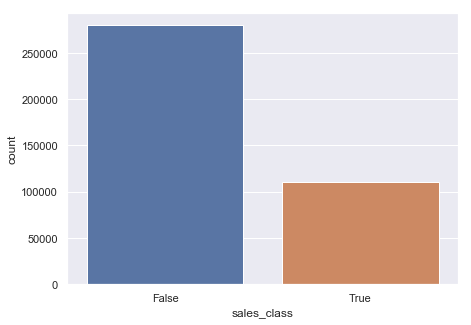

In [89]:
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(x='sales_class',data=summary_final_classifier)


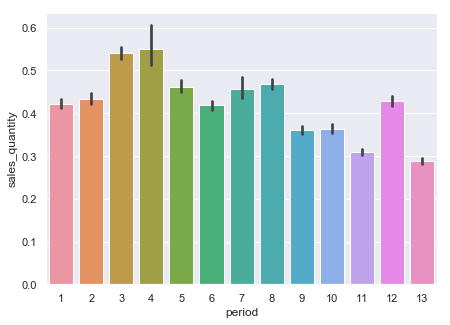

In [90]:
sns.barplot(x='period',y='sales_quantity',data=summary_final_classifier)

In [91]:
#creating dummy variables
cols=['brand','state','region', 'store_type', 'store_location', 'city_type',
       'case_size_range', 'gender', 'movement', 'material', 'dial_color',
       'strap_type', 'strap_color', 'precious_stone', 'glass', 'case_shape',
       'watch_type']
summary_final_classifier_dummies=pd.get_dummies(data=summary_final_classifier, columns=cols)

#for sales_quantity as the target variable
#creating seperate df for independent and dependent features
y_clf=summary_final_classifier_dummies.loc[:, summary_final_classifier_dummies.columns == 'sales_class']
X_clf=summary_final_classifier_dummies.drop(columns =['sales_quantity','item_no','billing','so', 'sales_class'])

#performing train and test split on data
X_train_clf,X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)
"""
split=0.2
test_clf=int(len(X_clf)*split)
train_clf=len(X_clf)-test_clf
X_train_clf=X_clf.head(train_clf)
y_train_clf=y_clf.head(train_clf)
X_test_clf=X_clf.tail(test_clf)
y_test_clf=y_clf.tail(test_clf)

"""

'\nsplit=0.2\ntest_clf=int(len(X_clf)*split)\ntrain_clf=len(X_clf)-test_clf\nX_train_clf=X_clf.head(train_clf)\ny_train_clf=y_clf.head(train_clf)\nX_test_clf=X_clf.tail(test_clf)\ny_test_clf=y_clf.tail(test_clf)\n\n'

In [92]:
summary_final_classifier.columns

Index(['item_no', 'period', 'state', 'region', 'brand', 'stock_prevailing_mrp',
       'store_type', 'store_location', 'city_type', 'case_size_range',
       'gender', 'movement', 'material', 'dial_color', 'strap_type',
       'strap_color', 'precious_stone', 'glass', 'case_shape', 'watch_type',
       'billing', 'sales_quantity', 'so', 'sales_class'],
      dtype='object')

In [93]:
#!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=11915027)
X_bal_clf, y_bal_clf = ros.fit_resample(X_train_clf, y_train_clf)
#classifier(X_bal,y_bal)

In [94]:
print (len(X_train_clf),len(X_bal_clf),len(y_train_clf),len(y_bal_clf))

counts=y_train_clf.iloc[:, 0].value_counts().to_frame(name='Before Balancing')
count1= pd.DataFrame(np.bincount(y_bal_clf.iloc[:, 0]))
counts['After Balancing'] = count1
counts

312123 447014 312123 447014


,Before Balancing,After Balancing
False,223507,223507
True,88616,223507


In [95]:
X_train_clf.shape

(312123, 188)

#### Defining function for computing confusion metrics

In [96]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve,auc
def cfm(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tnp=tn/(tn+fp)*100
    fpp=fp/(tn+fp)*100
    fnp=fn/(fn+tp)*100
    tpp=tp/(fn+tp)*100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    accuracy=metrics.accuracy_score(y_test, y_pred)*100
    return accuracy,tnp,fpp,fnp,tpp,roc_auc


## Decision Tree Classifier

In [97]:

d_tree_clfr = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=55)
d_tree_clfr.fit(X_bal_clf, y_bal_clf)
y_pred= d_tree_clfr.predict(X_test_clf)


In [98]:
output = []

In [99]:
accuracy,tnp,fpp,fnp,tpp,roc_auc = cfm(y_test_clf,y_pred)
output.append(['Decision Tree',accuracy,tnp,fpp,fnp,tpp,roc_auc])

#output=pd.DataFrame(output_list,columns=['Model','Accuracy%','TN%', 'FP%', 'FN%', 'TP%','AUC'])


### Logistic classifier - skip this one

In [100]:
#log_model = LogisticRegression(solver='newton-cg',multi_class='multinomial')
#log_model.fit(X_bal_clf,y_bal_clf)
#y_pred = log_model.predict(X_test_clf)
#log_accuracy = metrics.accuracy_score(y_test, y_pred)
#log_accuracy


In [101]:
#accuracy,tnp,fpp,fnp,tpp,roc_auc = cfm(y_test_clf,y_pred)
#output.append(['Log Regression',accuracy,tnp,fpp,fnp,tpp,roc_auc])


### LDA

In [102]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_bal_clf, y_bal_clf)
y_pred= lda_clf.predict(X_test_clf)
#lda_accuracy=metrics.accuracy_score(y_test, y_pred)


In [103]:
lda_clf.fit_transform(X_bal_clf, y_bal_clf)
y_pred= lda_clf.predict(X_test_clf)

In [104]:
accuracy,tnp,fpp,fnp,tpp,roc_auc = cfm(y_test_clf,y_pred)
output.append(['LDA',accuracy,tnp,fpp,fnp,tpp,roc_auc])


### MultinomialNB

In [106]:
mnb_clf = MultinomialNB()
mnb_clf.fit(X_bal_clf,y_bal_clf)
y_pred = mnb_clf.predict(X_test_clf)
#nb_accuracy=metrics.accuracy_score(y_test, y_pred)
accuracy,tnp,fpp,fnp,tpp,roc_auc = cfm(y_test_clf,y_pred)
output.append(['Naive Bayes',accuracy,tnp,fpp,fnp,tpp,roc_auc])

### XGB

In [413]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)
    
xgb_model.fit(X_bal_clf,y_bal_clf)

y_pred = xgb_model.predict(X_test_clf)


[08:07:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [414]:
print(confusion_matrix(y_test_clf, y_pred))
accuracy,tnp,fpp,fnp,tpp,roc_auc = cfm(y_test_clf,y_pred)

output.append(['XGB Classifier - Random CV',accuracy,tnp,fpp,fnp,tpp,roc_auc])

[[37528 18546]
 [ 7798 14159]]


In [415]:
df=pd.DataFrame(output,columns=['Model','Accuracy%','TN%', 'FP%', 'FN%', 'TP%','AUC'])

df.round(2)

,Model,Accuracy%,TN%,FP%,FN%,TP%,AUC
0,Decision Tree,65.63,67.04,32.96,37.97,62.03,0.65
1,Log Regression,63.11,62.42,37.58,35.12,64.88,0.64
2,LDA,63.04,62.24,37.76,34.92,65.08,0.64
3,Naive Bayes,56.25,51.84,48.16,32.46,67.54,0.60
4,XGB Classifier,67.77,68.42,31.58,33.88,66.12,0.67
5,XGB Classifier Tuned,67.77,68.42,31.58,33.88,66.12,0.67
6,XGB Classifier Tuned,67.77,68.42,31.58,33.88,66.12,0.67
7,XGB Classifier Tuned,67.77,68.42,31.58,33.88,66.12,0.67
8,XGB Classifier,67.77,68.42,31.58,33.88,66.12,0.67
9,XGB Classifier Tuned,67.25,67.92,32.08,34.47,65.53,0.67


#### Decision Tree - Tuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier
lst=[]
# X_train_clf, y_train_clf
for i in range(3,30,3): 
    d_tree_clfr = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=i)
    #Apply classifier on training dataset
    d_tree_clfr.fit(X_bal_clf,y_bal_clf)
    y_pred = d_tree_clfr.predict(X_test_clf)
    accuracy,tnp,fpp,fnp,tpp,roc_auc = cfm(y_test_clf,y_pred)
    lst.append([i,accuracy,tnp,fpp,fnp,tpp,roc_auc])

In [ ]:
cols=['SizeThreshold','Accuracy%','TN%', 'FP%', 'FN%', 'TP%','AUC']
df = pd.DataFrame(lst, columns=cols)
df=df.set_index("SizeThreshold")
df.round(2)

### Tuning using random search CV

### Decision Tree

In [439]:
param_dist = {"max_depth": np.linspace(5, 350, 350, endpoint=True), 
              "min_samples_leaf": np.linspace(0.05, 0.5, 25, endpoint=True), 
              "criterion": ["gini", "entropy"]} 
tree = DecisionTreeClassifier() 
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 5,scoring='roc_auc') 
tree_cv.fit(X_bal_clf, y_bal_clf) 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_)) 



Tuned Decision Tree Parameters: {'min_samples_leaf': 0.0875, 'max_depth': 326.2750716332378, 'criterion': 'entropy'}
Best score is 0.6125339445292078


### XG Boost Tuning

In [400]:
    
eval_set = [(X_test_clf, y_test_clf)]
eval_metric = ["auc","error"]


xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

#%time 
#eval_metric=eval_metric
xgb_model.fit(X_bal_clf,y_bal_clf,  early_stopping_rounds=5, eval_set=eval_set)






[0]	validation_0-auc:0.61498
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.65668
[2]	validation_0-auc:0.66817
[3]	validation_0-auc:0.67681
[4]	validation_0-auc:0.67882
[5]	validation_0-auc:0.68535
[6]	validation_0-auc:0.68942
[7]	validation_0-auc:0.69207
[8]	validation_0-auc:0.69395
[9]	validation_0-auc:0.69468
[10]	validation_0-auc:0.69767
[11]	validation_0-auc:0.70018
[12]	validation_0-auc:0.70271
[13]	validation_0-auc:0.70326
[14]	validation_0-auc:0.70346
[15]	validation_0-auc:0.70464
[16]	validation_0-auc:0.70564
[17]	validation_0-auc:0.70676
[18]	validation_0-auc:0.70695
[19]	validation_0-auc:0.70759
[20]	validation_0-auc:0.70998
[21]	validation_0-auc:0.71095
[22]	validation_0-auc:0.71211
[23]	validation_0-auc:0.71339
[24]	validation_0-auc:0.71388
[25]	validation_0-auc:0.71431
[26]	validation_0-auc:0.71596
[27]	validation_0-auc:0.71652
[28]	validation_0-auc:0.71653
[29]	validation_0-auc:0.71774
[30]	validation_0-auc:0.71786
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [402]:
#results = xgb_model.evals_result()
print(xgb_model)

# xgb_model.best_score, xgb_model.best_iteration,
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
best score: 0.735944, best iteration: 99, best ntree limit 100


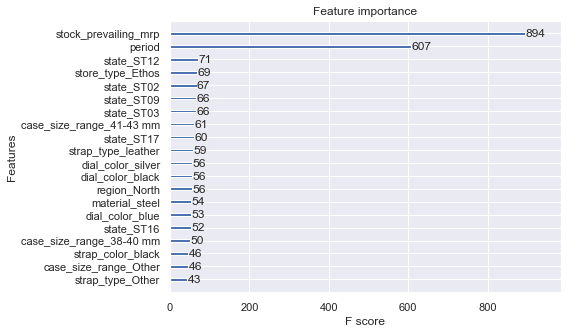

In [403]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [404]:
#xgb_model_tuned = xgb.XGBClassifier()
# xgb_model_tuned.fit(X_bal_clf,y_bal_clf)

y_pred = xgb_model.predict(X_test_clf)

accuracy,tnp,fpp,fnp,tpp,roc_auc = cfm(y_test_clf,y_pred)

output.append(['XGB Classifier Tuned',accuracy,tnp,fpp,fnp,tpp,roc_auc])

print('run')

run


In [405]:
df=pd.DataFrame(output,columns=['Model','Accuracy%','TN%', 'FP%', 'FN%', 'TP%','AUC'])

df.round(2)

,Model,Accuracy%,TN%,FP%,FN%,TP%,AUC
0,Decision Tree,65.63,67.04,32.96,37.97,62.03,0.65
1,Log Regression,63.11,62.42,37.58,35.12,64.88,0.64
2,LDA,63.04,62.24,37.76,34.92,65.08,0.64
3,Naive Bayes,56.25,51.84,48.16,32.46,67.54,0.60
4,XGB Classifier,67.77,68.42,31.58,33.88,66.12,0.67
5,XGB Classifier Tuned,67.77,68.42,31.58,33.88,66.12,0.67
6,XGB Classifier Tuned,67.77,68.42,31.58,33.88,66.12,0.67
7,XGB Classifier Tuned,67.77,68.42,31.58,33.88,66.12,0.67
8,XGB Classifier,67.77,68.42,31.58,33.88,66.12,0.67
9,XGB Classifier Tuned,67.25,67.92,32.08,34.47,65.53,0.67


## Random Search CV - XGB

In [401]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [406]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [407]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [410]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_clf, y_clf), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_bal_clf, y_bal_clf)
timer(start_time)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 153.0min finished


[01:48:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 Time taken: 3 hours 12 minutes and 2.3 seconds.


In [411]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv(data_path + 'xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([2130.84846489, 2634.72784734, 2597.19702458, 1964.61543989,
       2043.36283199]), 'std_fit_time': array([ 2.50628031, 50.04278941, 57.07208863, 12.27391175, 82.56670476]), 'mean_score_time': array([5.27770559, 7.61158895, 7.11344767, 7.11983665, 4.57681974]), 'std_score_time': array([0.24672524, 0.12731237, 0.06836437, 0.07878557, 0.64484841]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fil

#### Delete all classifier variables from memory

In [ ]:
#del X_train_clf, X_bal_clf,X_test_clf, y_train_clf
#del y_test_clf,y_pred, y_bal_clf
#del summary_final_classifier_dummies
#del summary_final_classifier



In [123]:
summary_final_pareto.head()

,item_no,period,state,region,brand,stock_prevailing_mrp,store_type,store_location,city_type,case_size_range,...,dial_color,strap_type,strap_color,precious_stone,glass,case_shape,watch_type,billing,sales_quantity,so
0,5100311,1,ST09,South,B008,10.727273,Ethos,Mall,Tier1,41-43 mm,...,white,leather,black,no,sapphire crystal,round,analog,10.727273,0.0,-11.512925
1,5100392,1,ST09,South,B008,17.600000,Ethos,Mall,Tier1,41-43 mm,...,silver,leather,brown,no,sapphire crystal,round,analog,17.600000,0.0,-11.512925
2,5104730,1,ST09,South,B048,7.062000,Ethos,DFS,Tier1,32-34 mm,...,brown,steel,silver,no,sapphire crystal,round,analog,7.062000,0.0,-11.512925
3,5106714,1,ST09,South,B063,19.500000,Ethos,Mall,Tier1,38-40 mm,...,silver,steel,silver,no,sapphire crystal,round,analog,19.500000,0.0,-11.512925
4,5106817,1,ST09,South,B063,7.200000,Ethos,Mall,Tier1,32-34 mm,...,white,steel,silver,no,sapphire crystal,rectangle,analog,7.200000,0.0,-11.512925


## Regression model on non-zero sales data

In [125]:
summary_final_pareto_reg = summary_final_pareto[summary_final_pareto['sales_quantity'] > 0]


#### Creating dummy variables for regression model

In [126]:
#creating dummy variables
cols=['brand','state','region', 'store_type', 'store_location', 'city_type',
       'case_size_range', 'gender', 'movement', 'material', 'dial_color',
       'strap_type', 'strap_color', 'precious_stone', 'glass', 'case_shape',
       'watch_type']
summary_final_dummies=pd.get_dummies(data=summary_final_pareto_reg, columns=cols)

print('Done')

Done


In [127]:
summary_final_dummies.shape


(110573, 191)

In [128]:
X_non_zero = summary_final_dummies[summary_final_dummies['sales_quantity'] > 0].iloc[0:10]

In [129]:
#for So as the target variable
#creating seperate df for independent and dependent features
y=summary_final_dummies.loc[:, summary_final_dummies.columns == 'sales_quantity']
X=summary_final_dummies.drop(columns =['sales_quantity','item_no','billing', 'so'])



In [130]:
summary_final_dummies.shape


(110573, 191)

In [131]:
#checking for duplicate column names
duplicate_columns = summary_final_dummies.columns[summary_final_dummies.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [132]:
#performing train and test split on data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


"""
split=0.2
test=int(len(X)*split)
train=len(X)-test
X_train=X.head(train)
y_train=y.head(train)
X_test=X.tail(test)
y_test=y.tail(test)
"""

'\nsplit=0.2\ntest=int(len(X)*split)\ntrain=len(X)-test\nX_train=X.head(train)\ny_train=y.head(train)\nX_test=X.tail(test)\ny_test=y.tail(test)\n'

In [133]:
y2 = summary_final_dummies.loc[:, summary_final_dummies.columns == 'so']
X_train2,X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42)

## Regression Modelling

In [136]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


## Linear regression on So

In [138]:
from sklearn.linear_model import LinearRegression
reg_model_so = LinearRegression()  
reg_model_so.fit(X_train2, y_train2)
preds_so = reg_model_so.predict(X_test2)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rmse = np.sqrt(mean_squared_error(y_test2, preds_so))
r2=r2_score(y_test2, preds_so)
print("Linear regression RMSE: %.2f, Test R2: %.2f" % (rmse,r2))

Linear regression RMSE: 0.48, Test R2: 0.68


## XGB Regression

In [188]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [189]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train2,y_train2)
preds = xg_reg.predict(X_test2)
rmse = np.sqrt(mean_squared_error(y_test2, preds))


In [190]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test2,preds)
print("Xgboost RMSE: %.2f, Test R2: %.2f" % (rmse,r2))

Xgboost RMSE: 3.08, Test R2: -12.26


In [191]:
params = {'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
          'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
          'colsample_bylevel':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
          'min_child_weight':[1,3,5,7] ,
          'reg_lambda':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
          'n_estimator':[3,5,7,10],
          'learning_rate': [0.05,0.1,0.15,0.2,0.25,0.3],
          'max_depth': [3,4,5,6,7,8,10,12,15], 
          'reg_alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
         }

In [192]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
#scoring='r2'
scoring='neg_mean_squared_error'
random_search=RandomizedSearchCV(xg_reg,param_distributions=params,scoring=scoring,n_iter=20,cv=5,verbose=3)


#### Do not run again - Best params below


In [ ]:
# random_search.fit(X_train2,y_train2) # clear output

In [194]:
#random_search.best_estimator_

"""
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.2,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=12,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimator=5, n_estimators=100, n_jobs=0, num_parallel_tree=1,
             random_state=0, reg_alpha=0.2, reg_lambda=0.7, scale_pos_weight=1,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)
"""

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.2,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=12,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimator=5, n_estimators=100, n_jobs=0, num_parallel_tree=1,
             random_state=0, reg_alpha=0.2, reg_lambda=0.7, scale_pos_weight=1,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [195]:
#random_search.best_params_

"""
{'subsample': 0.9,
 'reg_lambda': 0.7,
 'reg_alpha': 0.2,
 'n_estimator': 5,
 'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.15,
 'colsample_bytree': 0.9,
 'colsample_bylevel': 0.2}
 """

{'subsample': 0.9,
 'reg_lambda': 0.7,
 'reg_alpha': 0.2,
 'n_estimator': 5,
 'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.15,
 'colsample_bytree': 0.9,
 'colsample_bylevel': 0.2}

In [196]:
#best model based on the output of random_search.best_estimator_
best_gb=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=12,
             min_child_weight = 7, missing=np.nan,
              n_estimator=3, n_estimators=100,
             n_jobs=0, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0.5, reg_lambda=0.3, scale_pos_weight=1,
             subsample=0.2, tree_method='exact', validate_parameters=1,
             verbosity=0)

In [197]:
from sklearn.model_selection import cross_val_score as cvs
score=cvs(best_gb,X_train2,y_train2,cv=2,scoring='r2')

In [198]:
score

array([0.77404683, 0.77935373])

In [199]:
best_gb.fit(X_train2,y_train2)
preds = best_gb.predict(X_test2)
rmse = np.sqrt(mean_squared_error(y_test2, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.385794


In [200]:
from sklearn.metrics import r2_score
rmse = np.sqrt(mean_squared_error(y_test2, preds))
r2=r2_score(y_test2,preds)
print("RMSE: %.2f, R2: %.2f" % (rmse,r2))

RMSE: 0.39, R2: 0.79


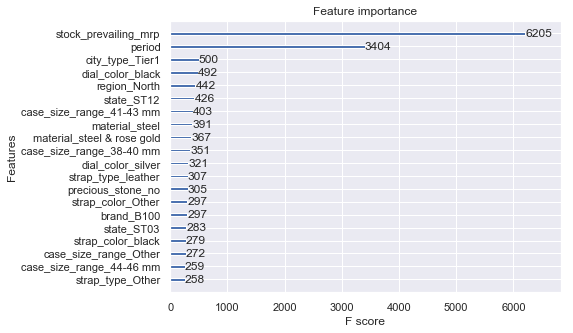

In [388]:
xgb.plot_importance(best_gb, max_num_features=20)

In [201]:
# delete dfs not to be used further here
"""del X_train2, y_train2
del summary_final_dummies
del summary_final_pareto_reg"""

'del X_train2, y_train2\ndel summary_final_dummies\ndel summary_final_pareto_reg'

# Predictions

### Prepare data for model input

In [309]:
dirpath = '/Users/parulgaba/Desktop/Capstone-Ethos/ConfidentialData/csvdata/'

data_path = '/Users/parulgaba/Desktop/Capstone-Ethos/ethos-retail-model/data/'

filename = data_path + 'regression_data/' + 'aggregated_summary_store_type_12_weeks.csv'

chunksize = 10 ** 5
rows=0
summary_df = pd.DataFrame()
for chunk in pd.read_csv(filename, chunksize=chunksize):
    summary_df=pd.concat([summary_df,chunk])
    rows+=chunk.shape[0]
print (rows)

476711


In [310]:
summary_df['stock_prevailing_mrp'] = summary_df['stock_prevailing_mrp'].div(10000)
summary_df['billing'] = summary_df['billing'].div(10000)

In [311]:
items_no_sales = summary_df.groupby(['item_no']).agg({'sales_quantity':'sum'}).reset_index()
unique_item_no_sales = items_no_sales[items_no_sales['sales_quantity'] == 0]['item_no'].unique()
summary_df = summary_df[~summary_df['item_no'].isin(unique_item_no_sales)]
print("Unique items removed with no sales at all for all 3 three years : " + str(len(unique_item_no_sales)))

Unique items removed with no sales at all for all 3 three years : 4324


In [312]:
cols_for_unique_selection = ["item_no","brand","case_size_range","gender","movement","material","dial_color","strap_type",
        "strap_color","precious_stone","glass","case_shape","watch_type"]
                             
unique_sku=summary_df[cols_for_unique_selection].drop_duplicates(cols_for_unique_selection)


In [313]:
#replace features from pareto
cols=['case_size_range', 'material', 'dial_color', 'strap_type', 'strap_color']
for col in cols:
    unique_sku[col] = np.where(unique_sku[col].isin(feature_mapping_dict[col]),'Other',unique_sku[col])
    

In [314]:
unique_sku.shape

print(len(unique_sku['item_no'].unique()))

unique_sku.shape

14749


(14751, 13)

In [315]:
#replace items with Others - replace brands first
unique_sku['brand'] = np.where(unique_sku['item_no'].isin(item_mapping_list),'Others',unique_sku['brand'])
unique_sku['item_no'] = np.where(unique_sku['item_no'].isin(item_mapping_list),'Others',unique_sku['item_no'])
print(len(unique_sku['item_no'].unique()))

unique_sku.shape

10591


(14751, 13)

In [316]:
unique_sku.columns

Index(['item_no', 'brand', 'case_size_range', 'gender', 'movement', 'material',
       'dial_color', 'strap_type', 'strap_color', 'precious_stone', 'glass',
       'case_shape', 'watch_type'],
      dtype='object')

In [322]:
summarize_method = {
    # 'product_group_code' :'first', # why did we not pick this column
    # 'days_to_sell' :'mean', where in the process is this used
      # 'case_size' :'mean', Why was this dropped
   'case_size_range' :'first', 'gender' :'first', 'movement' :'first', 
    'material' :'first', 
    'dial_color' :'first',
   'strap_type' :'first', 'strap_color' :'first', 'precious_stone' :'first', 
    'glass' :'first', 'case_shape' :'first',
   'watch_type' :'first'
}

unique_sku = unique_sku.groupby(['item_no', 'brand']).agg(summarize_method).reset_index()

unique_sku.shape



(10589, 13)

In [323]:
unique_sku['period'] = 15

In [324]:
store_master = pd.read_csv(data_path + "store_master_with_state_and_regions.csv")


In [325]:
store_master.columns

Index(['store_code', 'store_type', 'store_location', 'city_type', 'region',
       'state', 'Status'],
      dtype='object')

In [326]:
store_master[store_master['store_code'] == 'S28']

,store_code,store_type,store_location,city_type,region,state,Status
132,S28,Ethos,Mall,Tier1,West,ST12,ok


### Item MRPs

In [327]:
item_mrp = pd.read_excel(data_path + 'itemMRP_encoded.xlsx')

item_mrp['item_no'] = np.where(item_mrp['item_no'].isin(item_mapping_list),'Others',item_mrp['item_no'])
item_mrp['brand'] = np.where(item_mrp['item_no'].isin(item_mapping_list),'Others',item_mrp['brand'])
item_mrp = item_mrp.rename(columns={"MRP": "stock_prevailing_mrp"})

item_mrp_agg = item_mrp.groupby(['item_no', 'brand']).agg({'stock_prevailing_mrp':'mean'}).reset_index()



In [328]:
item_mrp_agg.columns

Index(['item_no', 'brand', 'stock_prevailing_mrp'], dtype='object')

In [329]:
item_mrp_agg.columns[item_mrp_agg.isna().any()].tolist()

['stock_prevailing_mrp']

In [330]:
item_mrp_agg = item_mrp_agg[['item_no', 'stock_prevailing_mrp']][~item_mrp_agg['stock_prevailing_mrp'].isin([np.inf, -np.inf, np.nan])]
item_mrp_agg.shape


(14943, 2)

In [331]:

item_mrp_agg.drop_duplicates(subset='item_no', inplace=True)

unique_sku['item_no'] = unique_sku['item_no'].astype(str)
item_mrp_agg['item_no'] = item_mrp_agg['item_no'].astype(str)

print(item_mrp_agg.shape)
print (pd.merge(unique_sku, item_mrp_agg, left_on='item_no', right_on='item_no', how='inner').shape)

unique_sku = pd.merge(unique_sku, item_mrp_agg, left_on='item_no', right_on='item_no', how='inner')


(14908, 2)
(10588, 15)


In [332]:
unique_sku = unique_sku.fillna(0)

In [333]:
unique_sku.columns[unique_sku.isna().any()].tolist()

[]

In [334]:
unique_sku['stock_prevailing_mrp'] = unique_sku['stock_prevailing_mrp'].div(10000)

In [335]:
unique_sku.head()

,item_no,brand,case_size_range,gender,movement,material,dial_color,strap_type,strap_color,precious_stone,glass,case_shape,watch_type,period,stock_prevailing_mrp
0,5100311,B008,41-43 mm,Men,quartz,steel,white,leather,black,no,sapphire crystal,round,analog,15,9.69
1,5100392,B008,41-43 mm,Men,automatic,steel,silver,leather,brown,no,sapphire crystal,round,analog,15,16.86
2,5102171,B010,Other,Women,automatic,rose gold,silver,Other,Other,on bezel & dial,sapphire crystal,round,analog,15,84.26
3,5102310,B013,38-40 mm,Men,automatic,Other,silver,leather,black,no,sapphire crystal,round,analog,15,112.28
4,5103271,B027,32-34 mm,Men,others,Other,Other,others,silver,no,sapphire crystal,round,analog,15,208.00


### Create dummies

In [336]:
#creating dummy variables
cols=['brand','case_size_range', 'gender', 'movement', 'material', 'dial_color',
       'strap_type', 'strap_color', 'precious_stone', 'glass', 'case_shape',
       'watch_type']
unique_sku_dummies=pd.get_dummies(data=unique_sku, columns=cols)




### Add store dummies

In [337]:
store_dummies = [
    'state_ST02', 'state_ST03', 'state_ST05', 'state_ST07', 'state_ST09', 'state_ST12', 'state_ST13', 'state_ST15', 'state_ST16', 
    'state_ST17', 'state_ST19', 'state_ST21', 'state_ST24', 'state_ST28', 'region_East', 'region_North', 'region_South',
'region_West', 'store_type_Ethos', 'store_type_Large', 'store_type_Summit', 'store_location_Airport', 'store_location_DFS', 
    'store_location_High Street', 'store_location_Mall', 'city_type_Tier1', 'city_type_Tier2'
]

In [338]:
for col in store_dummies:
    unique_sku_dummies[col] = 0

In [339]:
unique_sku_dummies.shape

(10588, 189)

In [340]:
store_no = 'S28'

In [341]:
store_cols = ["state","region","store_type","store_location","city_type"]

for col in store_cols:
    dummy_col_name = col + '_' + store_master[store_master['store_code'] == store_no][col].unique()[0]
    print(dummy_col_name)
    unique_sku_dummies[dummy_col_name] = 1


state_ST12
region_West
store_type_Ethos
store_location_Mall
city_type_Tier1


In [342]:
unique_sku_dummies.shape

(10588, 189)

In [343]:
X_data=unique_sku_dummies.drop(columns =['item_no'])

X_data.shape

(10588, 188)

In [344]:
X_train_clf.shape

(312123, 188)

### Find missing dummies if any left and append as 0s

In [345]:
#np.setdiff1d(X_train_clf, X_data)

missing_dummies_set = set(X_bal_clf) - set(X_data)
print(missing_dummies_set)

set()


In [ ]:
del list 
# list callable is used as a variable above - To be cleaned up and renamed. For now delete the variable and use list callable below


In [349]:
missing_dummies_cols = list(missing_dummies_set)
for col in missing_dummies_cols:
    X_data[col] = 0

In [350]:
# Check if any missing after this

missing_dummies_set = set(X_data) - set(X_bal_clf)
print(missing_dummies_set)
    

set()


In [351]:
missing_dummies_cols = list(missing_dummies_set)
for col in missing_dummies_cols:
    X_data = X_data.drop(columns = [col])
X_data.shape

(10588, 188)

In [352]:
X_bal_clf.columns

Index(['period', 'stock_prevailing_mrp', 'brand_B007', 'brand_B008',
       'brand_B010', 'brand_B013', 'brand_B014', 'brand_B017', 'brand_B018',
       'brand_B020',
       ...
       'case_shape_rectangle', 'case_shape_round', 'case_shape_square',
       'case_shape_tonneau', 'watch_type_activity tracker',
       'watch_type_analog', 'watch_type_analog-digital', 'watch_type_digital',
       'watch_type_hybrid smart watch', 'watch_type_smart watch'],
      dtype='object', length=188)

In [353]:
print(set(X_bal_clf) - set(X_data))

set()


In [354]:
X_data.columns

Index(['period', 'stock_prevailing_mrp', 'brand_B007', 'brand_B008',
       'brand_B010', 'brand_B013', 'brand_B014', 'brand_B017', 'brand_B018',
       'brand_B020',
       ...
       'region_West', 'store_type_Ethos', 'store_type_Large',
       'store_type_Summit', 'store_location_Airport', 'store_location_DFS',
       'store_location_High Street', 'store_location_Mall', 'city_type_Tier1',
       'city_type_Tier2'],
      dtype='object', length=188)

## Classifier predictions

In [355]:
#y_pred= lda_clf.predict(X_data) # Predicts something positive
#y_pred = d_tree_clfr.predict(X_data) # Predicts low positives
# y_pred = mnb_clf.predict(X_data) # Predicts half positives than lda
#y_pred = log_model.predict(X_data) # Predicts higher positives than lda

f_names = xgb_model.get_booster().feature_names
df = X_data[f_names]
y_pred = xgb_model.predict(df) # xgb classifier

In [356]:
y_pred

array([False, False, False, ..., False, False,  True])

In [357]:
unique_sku.shape

(10588, 15)

In [358]:
len(y_pred)

10588

In [359]:
unique_sku_dummies['sales_class'] = y_pred
unique_sku_pred = unique_sku
unique_sku_pred['sales_class'] = y_pred

#### Filter items from unique sku classified as non-zero sales

In [360]:
items_classified_for_sales = unique_sku_dummies[unique_sku_dummies['sales_class']]['item_no'].unique()


In [361]:
unique_sku_dummies[unique_sku_dummies['sales_class']].shape

(3892, 190)

In [362]:
len(items_classified_for_sales)

3892

## Regression predictions on so

In [363]:
unique_sku_dummies_so = unique_sku_dummies[unique_sku_dummies['sales_class']]
X_data_so = unique_sku_dummies_so.drop(columns =['item_no'])
X_data_so.shape

(3892, 189)

In [364]:
missing_dummies_set = set(X_data_so) - set(X_train2)
print(missing_dummies_set)

{'sales_class', 'brand_B179'}


In [365]:
X_data_so = X_data_so.drop(columns = list(missing_dummies_set))

In [366]:
missing_dummies_set = set(X_train2) - set(X_data_so)
print(missing_dummies_set)

set()


In [367]:
f_names = best_gb.get_booster().feature_names
df = X_data_so[f_names]

In [368]:
pred_non_zero = best_gb.predict(df)
#pred_non_zero = reg_model_so.predict(X_data.drop(columns = list(set(X_data) - set(X_train2))))
#print(X_data.shape, X_train2.shape)
#print(set(X_data) - set(X_train2))


In [369]:
pred_non_zero

array([-8.762845, -8.778498, -8.797825, ..., -8.498654, -8.529373,
       -9.235309], dtype=float32)

### Add predictions to unique sku store df (input df created for particular store)

In [370]:
print (store_no)

S28


In [371]:
unique_sku_pred.shape

(10588, 16)

In [372]:
len(pred_non_zero)

3892

In [373]:

predictions_for_store = pd.DataFrame()
predictions_for_store = pd.concat([predictions_for_store,unique_sku_pred[unique_sku_pred['sales_class']]])

#predictions_for_store = pd.concat([predictions_for_store,unique_sku_pred])
predictions_for_store.shape

(3892, 16)

In [374]:
predictions_for_store['so'] = pred_non_zero

In [375]:
predictions_for_store.head()

,item_no,brand,case_size_range,gender,movement,material,dial_color,strap_type,strap_color,precious_stone,glass,case_shape,watch_type,period,stock_prevailing_mrp,sales_class,so
4,5103271,B027,32-34 mm,Men,others,Other,Other,others,silver,no,sapphire crystal,round,analog,15,208.0,True,-8.762845
5,5103485,B027,26-28 mm,Women,quartz,steel,white,steel,silver,no,sapphire crystal,square,analog,15,30.4,True,-8.778498
6,5103490,B027,41-43 mm,Men,automatic,steel & yellow gold,white,leather,black,no,sapphire crystal,rectangle,analog,15,69.5,True,-8.797825
7,5103492,B027,41-43 mm,Men,automatic,steel,white,leather,black,no,sapphire crystal,square,analog,15,50.5,True,-8.834607
8,5103501,B027,35-37 mm,Men,automatic,steel,white,leather,black,no,sapphire crystal,rectangle,analog,15,45.1,True,-8.852285


In [376]:
greedy_input = predictions_for_store[['item_no', 'brand', 'so']]

In [377]:
greedy_input.shape

(3892, 3)

In [378]:
greedy_input.head()

,item_no,brand,so
4,5103271,B027,-8.762845
5,5103485,B027,-8.778498
6,5103490,B027,-8.797825
7,5103492,B027,-8.834607
8,5103501,B027,-8.852285


In [379]:
greedy_input.to_csv(data_path + 'greedy_input_xgb.csv', header=True)

In [380]:
greedy_input['item_no'].unique()

array(['5103271', '5103485', '5103490', ..., '5196559', '5196566',
       'Others'], dtype=object)

In [381]:
len(greedy_input['item_no'].unique())

3892